In [1]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
SLICE_FOLDER = '../data/RadCTTACEomics_1685/1685/10_AP_Ax2.50mm/'
#SLICE_FOLDER = '../data/RadCTTACEomics_1685/1685/40_RTRD_Ax2.50mm/'

In [3]:
# load dicom slice files
slices = [pydicom.dcmread(os.path.join(SLICE_FOLDER, f)) 
          for f in os.listdir(SLICE_FOLDER) if f.endswith('.dcm')]

# sort slices by SliceLocation (or InstanceNumber)
slices.sort(key=lambda x: int(x.SliceLocation))

# Stack into 3D volume
volume = np.stack([s.pixel_array for s in slices], axis=0)


In [4]:
slices[0].ImagePositionPatient

[-215.5, -110.5, 976]

In [14]:
slices[0]

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 174
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113704.1.111.3956.1410855854.4865
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 192'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008,0012) Instance Creation Date              DA: ''
(0008,0013) Instance Creation Time              TM: '102414'
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0017) Acquisition UID                     UI: 1801

In [19]:
slices[10].SliceLocation

'-951.00'

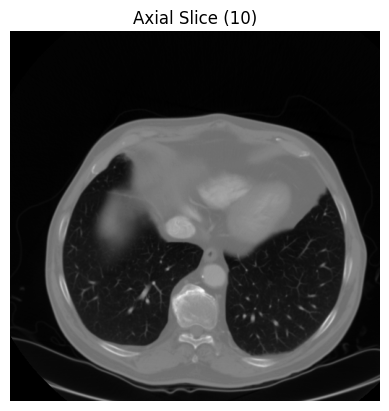

In [9]:
def visualize_slice(index, volume):
    plt.imshow(volume[index], cmap='gray')
    plt.title(f'Axial Slice ({index})')
    plt.axis('off')
    plt.show()

visualize_slice(10, volume)

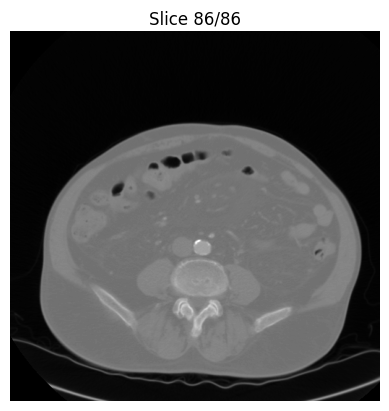

In [10]:
# create a gif animation looping through the slices
fig, ax = plt.subplots()
frame = ax.imshow(volume[0], cmap='gray')
ax.set_title('CT Volume Animation')
ax.axis('off')

def update(i):
    frame.set_data(volume[i])
    ax.set_title(f'Slice {i + 1}/{volume.shape[0]}')
    return frame,

ani = animation.FuncAnimation(fig, update, frames=volume.shape[0], interval=100, blit=True)
ani.save("../data/results/ct_slices.gif", writer='pillow', fps=10)

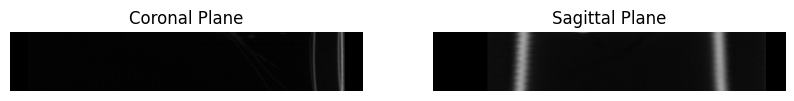

In [21]:
# Create a coronal-sagittal plane rotation animation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Initialize coronal and sagittal planes
coronal_frame = ax[0].imshow(volume[:, :, volume.shape[2] // 2], cmap='gray')
sagittal_frame = ax[1].imshow(volume[:, volume.shape[1] // 2, :], cmap='gray')

ax[0].set_title('Coronal Plane')
ax[1].set_title('Sagittal Plane')

for a in ax:
    a.axis('off')

def update_rotation(i):
    # Rotate through coronal and sagittal planes
    coronal_frame.set_data(volume[:, :, i])
    sagittal_frame.set_data(volume[:, i, :])
    return coronal_frame, sagittal_frame

ani_rotation = animation.FuncAnimation(
    fig, update_rotation, frames=volume.shape[2], interval=100, blit=True
)

ani_rotation.save("../data/results/coronal_sagittal_rotation.gif", writer='pillow', fps=10)

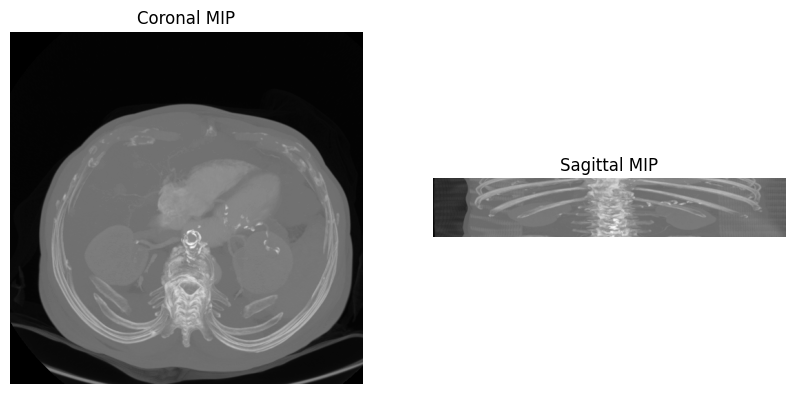

In [22]:
# Create a rotating MIP animation for coronal-sagittal planes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Initialize coronal and sagittal MIP frames
coronal_mip_frame = ax[0].imshow(np.max(volume, axis=0), cmap='gray')
sagittal_mip_frame = ax[1].imshow(np.max(volume, axis=1), cmap='gray')

ax[0].set_title('Coronal MIP')
ax[1].set_title('Sagittal MIP')

for a in ax:
    a.axis('off')

def update_mip(i):
    # Rotate through the volume for MIP
    coronal_mip = np.max(volume[:, :, :i+1], axis=0)
    sagittal_mip = np.max(volume[:, :i+1, :], axis=1)
    coronal_mip_frame.set_data(coronal_mip)
    sagittal_mip_frame.set_data(sagittal_mip)
    return coronal_mip_frame, sagittal_mip_frame

ani_mip = animation.FuncAnimation(
    fig, update_mip, frames=volume.shape[2], interval=100, blit=True
)

ani_mip.save("../data/results/rotating_mip_coronal_sagittal.gif", writer='pillow', fps=10)